### Let's demonstrate the image formation pipeline in ``cryojax``.

In [1]:
# Jax imports
import equinox as eqx
import jax
import jax.numpy as jnp
import numpy as np
from jax import config

config.update("jax_enable_x64", False)

In [2]:
# Plotting imports and function definitions
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [3]:
def plot_image(image, fig, ax, cmap="gray", label=None, **kwargs):
    im = ax.imshow(image, cmap=cmap, origin="lower", **kwargs)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im, cax=cax)
    if label is not None:
        ax.set(title=label)
    return fig, ax

In [4]:
# Image simulator imports
import cryojax.simulator as cs
from cryojax.utils import rfftn, irfftn, make_frequencies

In [5]:
# Volume filename and metadata
filename = "../tests/data/3jar_13pf_bfm1_ps5_28.mrc"

First we must read in our template into a given volume representation of the ``Ensemble``. We also must choose its ``Pose``.

In [6]:
# Read template into either an ElectronCloud or ElectronGrid
#density = cs.RealVoxelGrid.from_file(filename, crop_scale=0.9)
density = cs.VoxelCloud.from_file(filename)
#density = cs.FourierVoxelGrid.from_file(filename, pad_scale=1.5)
pose = cs.EulerPose(offset_x=-50.0, offset_y=20.0, view_phi=-20., view_theta=100., view_psi=20.)
ensemble = cs.Ensemble(density=density, pose=pose)

Next we have to choose a scattering (or in this case, projection) method. This will depend on the ``ElectronDensity`` representation.

In [7]:
# Configure the image formation process
shape = (81, 82)
pixel_size = 5.28  # Angstroms
manager = cs.ImageManager(shape=shape, pad_scale=1.5)
scattering = cs.NufftProject(manager, pixel_size=pixel_size, eps=1e-5)
#scattering = cs.FourierSliceExtract(manager, pixel_size=pixel_size)

Now, it's time to configure the imaging instrument. This, at minimum, requires an ``Optics`` model. Here, we also include models of the ``Exposure`` to the electron beam, and the ``Detector``. For example, by default the optics model is ``NullOptics``. Here, we configure multiple instruments to demonstrate different stages of the image formation pipeline.

In [8]:
# Initialize the instrument
optics = cs.CTFOptics(defocus_u=10000, defocus_v=10000, amplitude_contrast=.07)
exposure = cs.UniformExposure(N=1000, mu=0.0)
detector = cs.GaussianDetector(variance=cs.Constant(1.0))
instrument_s = cs.Instrument(exposure=exposure)
instrument_o = cs.Instrument(exposure=exposure, optics=optics)
instrument_d = cs.Instrument(exposure=exposure, optics=optics, detector=detector)

Now, choose a model for the solvent. By default, this is just ``NullIce``. Here, we model the ice as gaussian colored noise with ``GaussianIce``.

In [9]:
# Then, choose a model for the solvent
solvent = cs.GaussianIce(variance=cs.Exp(amplitude=5.0, scale=7.5))

Finally, we can initialize our imaging model.

In [10]:
# Image formation models
scattering_model = cs.ImagePipeline(scattering=scattering, ensemble=ensemble, instrument=instrument_s, solvent=solvent)
optics_model = cs.ImagePipeline(scattering=scattering, ensemble=ensemble, instrument=instrument_o, solvent=solvent)
detector_model = cs.ImagePipeline(scattering=scattering, ensemble=ensemble, instrument=instrument_d, solvent=solvent)

In [11]:
# Plot models
key = jax.random.PRNGKey(0)
fig, axes = plt.subplots(ncols=3, figsize=(12, 6))
ax1, ax2, ax3 = axes
im1 = plot_image(scattering_model(key), fig, ax1, label="Exit plane")
im2 = plot_image(optics_model(key), fig, ax2, label="Detector plane")
im3 = plot_image(detector_model(key), fig, ax3, label="Detector readout")
plt.tight_layout()

: 

Models can also include ``Filter``s. The following is a demonstration of a ``WhiteningFilter`` and a ``LowpassFilter``. These are precomputed upon initialization and applied automatically in the image formation pipeline. 

To compute a ``WhiteningFilter``, we first have to generate some synthetic data of structured noise from which we may compute its power spectrum.

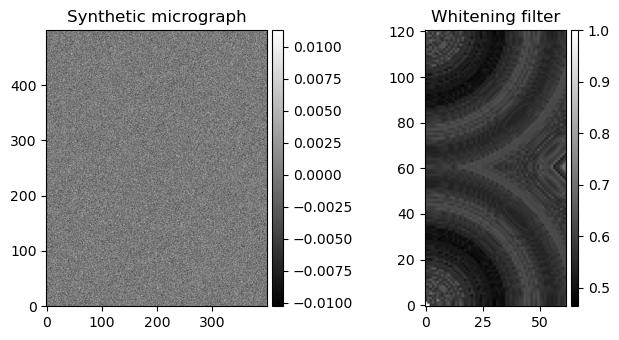

In [ ]:
# Instantiate image filters
fig, axes = plt.subplot_mosaic("""
AAAABBB
""", figsize=(6.5, 3.5))
key1, key2 = jax.random.split(jax.random.PRNGKey(1234))
micrograph_shape = (500, 400)
freqs = make_frequencies(micrograph_shape, pixel_size)
fourier_micrograph = solvent.sample(key1, freqs) * optics(freqs) + detector.sample(key2, freqs)
micrograph = irfftn(fourier_micrograph, s=micrograph_shape)
whiten = cs.WhiteningFilter(scattering.manager.padded_frequency_grid, micrograph)
plot_image(micrograph, fig, axes["A"], label="Synthetic micrograph")
plot_image(whiten.filter, fig, axes["B"], label="Whitening filter")
plt.tight_layout()

Now generate an image with the toy icy structured noise model with a given whitening filter. We will also apply a low pass filter and a circular mask.

(<Figure size 350x350 with 2 Axes>, <Axes: >)

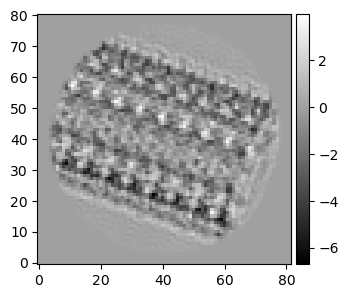

In [ ]:
# Show forward model for a whitened image
fig, ax = plt.subplots(figsize=(3.5, 3.5))
filter = cs.LowpassFilter(scattering.manager.padded_frequency_grid, cutoff=0.95) * whiten
mask = cs.CircularMask(scattering.manager.coordinate_grid)
whitened_model = cs.ImagePipeline(scattering=scattering, ensemble=ensemble, instrument=instrument_d, filter=filter, mask=mask)
plot_image(whitened_model.render(), fig, ax)